<a href="https://colab.research.google.com/github/Tkaheva/MO/blob/main/jun_ml_extra_tech_stack_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stacking

Предлагаем вам на примере решения модельной задачи самим убедиться в верности утверждения, что стекинг не всегда существенно повышает качество лучшего из базовых алгоритмов, но если этот алгоритм убрать из базовых, то и качество стекинга не сильно упадет.

Запустите следующие 4 ячейки.

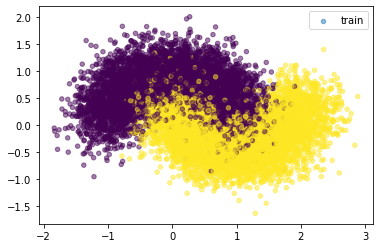

In [ ]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


x, y = make_moons(15000, noise=0.3, random_state=17)

train, test, train_true, test_true = train_test_split(x,
                                                      y,
                                                      train_size=0.7,
                                                      random_state=17)

x_train, valid, y_train, valid_true = train_test_split(train,
                                                      train_true,
                                                      train_size=0.6,
                                                      random_state=17)

plt.scatter(train[:, 0], train[:, 1], c=train_true, s=20, alpha=0.5, label='train')
plt.legend()

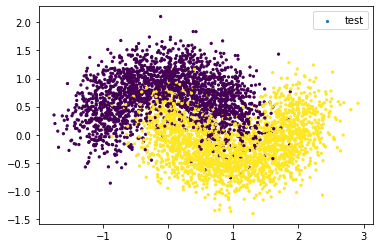

In [ ]:
plt.scatter(test[:, 0], test[:, 1], c=test_true, s=5, alpha=1.0, label='test')
plt.legend()

/home/impuling/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/impuling/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


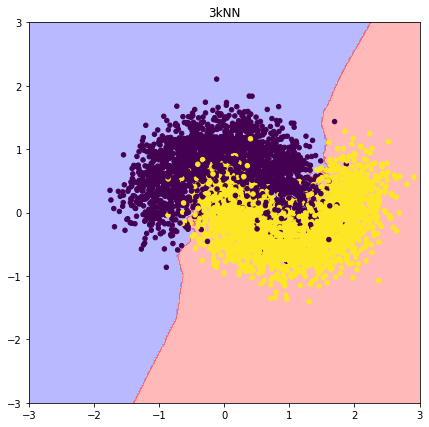

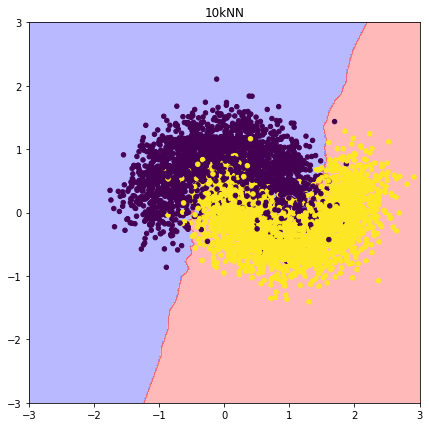

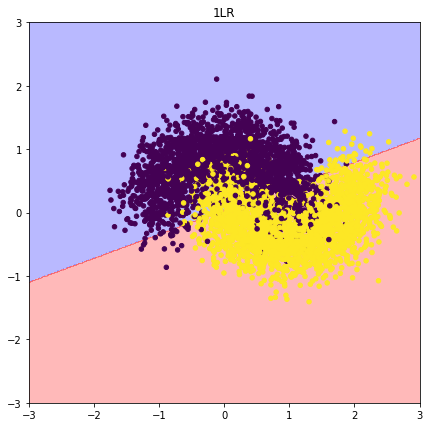

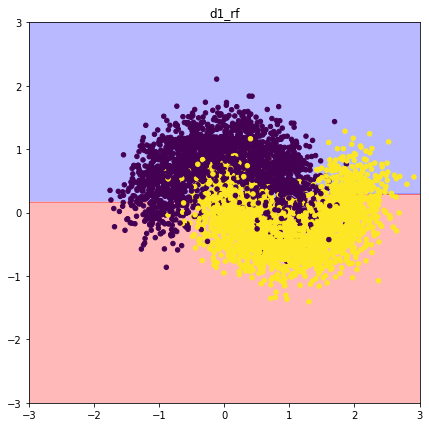

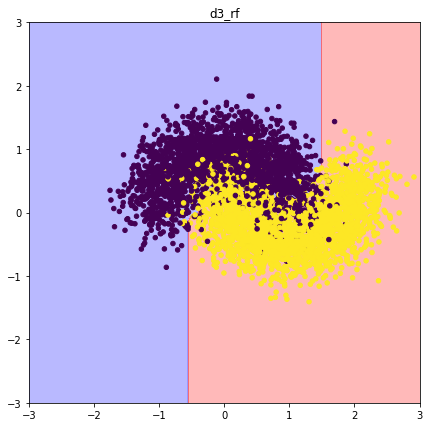

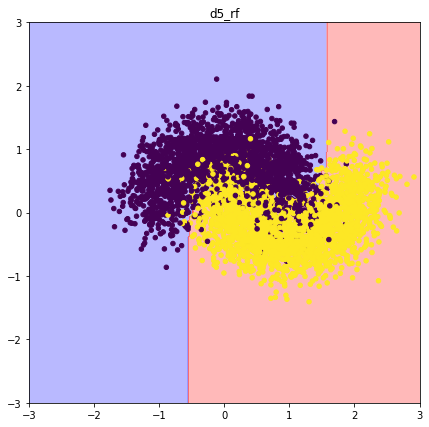

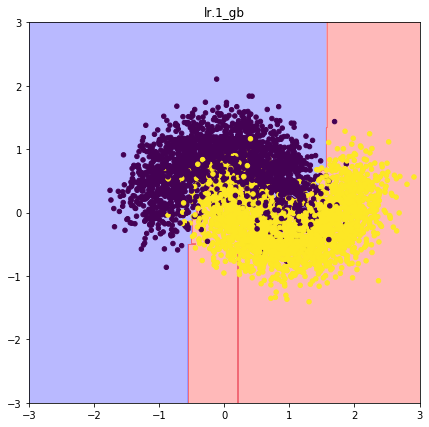

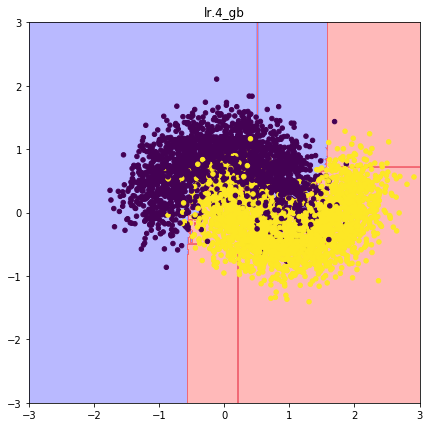

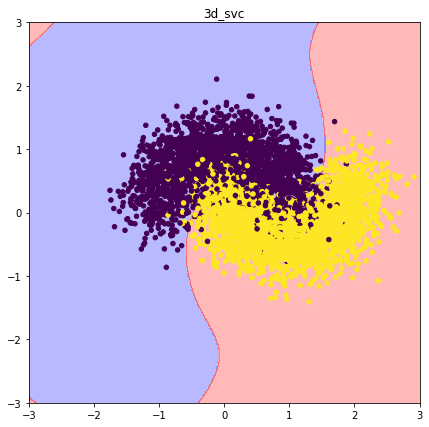

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

def plot(alg, data, targets, label):
    xx, yy = np.meshgrid(np.linspace(-3., 3., 500), np.linspace(-3., 3., 500))
    Z = alg.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(7, 7))
    plt.contourf(xx, yy, Z, levels=10, cmap=plt.cm.bwr, alpha=0.3)

    plt.scatter(data[:, 0], data[:, 1], s=20, c=targets)

    plt.xlim((-3, 3))
    plt.ylim((-3, 3))
    plt.title(label)


knn1 = KNeighborsClassifier(n_neighbors=3)
knn1.fit(x_train, y_train)
plot(knn1, test, test_true, '3kNN')

knn2 = KNeighborsClassifier(n_neighbors=10)
knn2.fit(x_train, y_train)
plot(knn2, test, test_true, '10kNN')

lr = LogisticRegression(C=10, random_state=17)
lr.fit(x_train, y_train)
plot(lr, test, test_true, '1LR')

rf1 = RandomForestClassifier(n_estimators=100, max_depth=1, random_state=17)
rf1.fit(x_train, y_train)
plot(rf1, test, test_true, 'd1_rf')

rf2 = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=17)
rf2.fit(x_train, y_train)
plot(rf2, test, test_true, 'd3_rf')

rf3 = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=17)
rf3.fit(x_train, y_train)
plot(rf3, test, test_true, 'd5_rf')

gb1 = GradientBoostingClassifier(learning_rate=0.1, random_state=17)
gb1.fit(x_train, y_train)
plot(gb1, test, test_true, 'lr.1_gb')

gb2 = GradientBoostingClassifier(learning_rate=0.4, random_state=17)
gb2.fit(x_train, y_train)
plot(gb2, test, test_true, 'lr.4_gb')

svc = SVC(degree=3, random_state=17)
svc.fit(x_train, y_train)
plot(svc, test, test_true, '3d_svc')

0 auc: 0.8971313863234087
1 auc: 0.9139757690299333
2 auc: 0.8522046357837013
3 auc: 0.8215518046981363
4 auc: 0.8926628837592676
5 auc: 0.9040736424237767
6 auc: 0.9173543856917827
7 auc: 0.9066244476235391
8 auc: 0.9155762703794241
Stacking AUC: 0.9164530787967851


Text(0, 0.5, 'AUC')

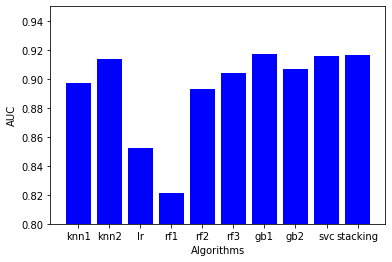

In [ ]:
models = [knn1, knn2, lr, rf1, rf2, rf3, gb1, gb2, svc]
meta_mtrx = np.empty((valid.shape[0], len(models))) # (кол-во объектов, 4 алгоритма)

for n, model in enumerate(models):
    meta_mtrx[:, n] = model.predict(valid)
    predicted = model.predict(test)
    print(f'{n} auc: {roc_auc_score(test_true, predicted)}')

meta = GradientBoostingClassifier(n_estimators=60, random_state=17)
meta_model = meta.fit(meta_mtrx, valid_true)

meta_mtrx_test = np.empty((test.shape[0], len(models)))

for n, model in enumerate(models):
    meta_mtrx_test[:, n] = model.predict(test)

meta_predict = meta.predict(meta_mtrx_test)
print(f'Stacking AUC: {roc_auc_score(test_true, meta_predict)}')


# построим графики, где по оси  yy  значения AUC для всех классификаторов, а по оси  xx  - сами алгоритмы.

alg = ['knn1', 'knn2', 'lr', 'rf1', 'rf2', 'rf3', 'gb1', 'gb2', 'svc', 'stacking'] # названия алгоритмов
auc = [] # значения auc для alg
for model in models:
    predicted = model.predict(test)
    auc.append(roc_auc_score(test_true, predicted))
auc.append(roc_auc_score(test_true, meta_predict))

plt.bar(np.arange(len(auc)), auc, color='blue', label='алгоритмы')
plt.xticks(np.arange(len(auc)), alg)
plt.ylim([0.8, 0.95])
plt.xlabel('Algorithms')
plt.ylabel('AUC')

Теперь предлагаем вам самостоятельно построить мета-модель без метапризнаков двух лучших алгоритмов (gb1 и svc1) и посмотреть на подобном графике, насколько сильно отличаются значения AUC мета-алгоритмов.

In [ ]:
models = [knn1, knn2, lr, rf1, rf2, rf3, gb2]
meta_mtrx = np.empty((valid.shape[0], len(models)))

for n, model in enumerate(models):
    # сделайте предсказания для валидационных данных
    # ваш код

meta = GradientBoostingClassifier(n_estimators=5, random_state=17)
# обучите мета-модель на валидационных данных
# ваш код

meta_mtrx_test = np.empty((test.shape[0], len(models)))

for n, model in enumerate(models):
    # ваш код

# сделайте предсказания для мета-алгоритма
# ваш код

# выведите график для всех обученных моделей (включая gb1 и svc) и stacking'а, обученного на них
# выведите здесь же график для нового значения auc stacking'а, укажите color='red'
# ваш код

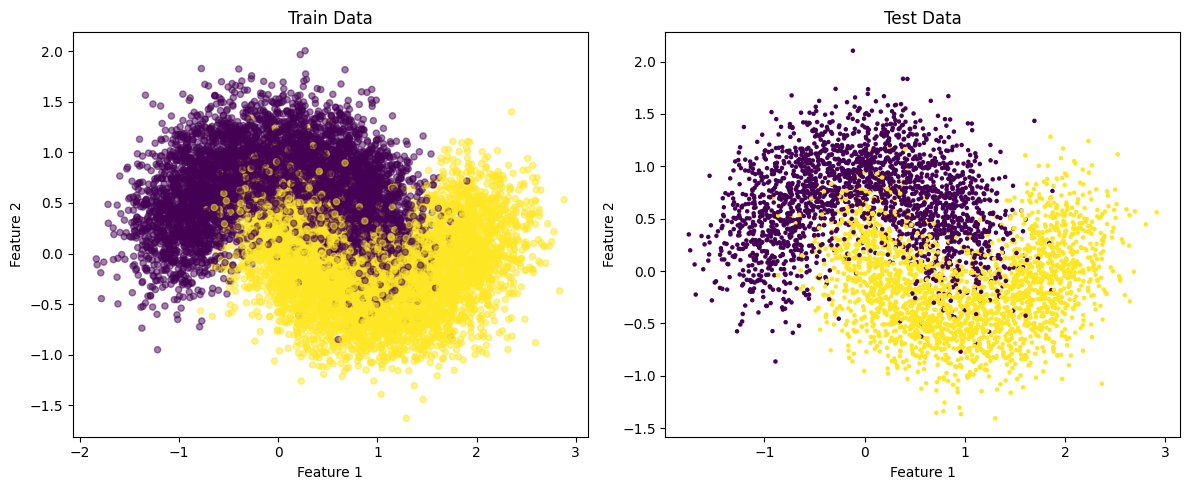

Инициализация и обучение базовых моделей...

Оригинальный стекинг со всеми моделями
AUC базовых моделей:
  Модель 0: 0.8971
  Модель 1: 0.9140
  Модель 2: 0.8520
  Модель 3: 0.8216
  Модель 4: 0.8927
  Модель 5: 0.9041
  Модель 6: 0.9174
  Модель 7: 0.9073
  Модель 8: 0.9160
Stacking AUC (все модели): 0.9164

Стекинг без двух лучших моделей (gb1 и svc)
AUC базовых моделей (без gb1 и svc):
  Модель 0: 0.8971
  Модель 1: 0.9140
  Модель 2: 0.8520
  Модель 3: 0.8216
  Модель 4: 0.8927
  Модель 5: 0.9041
  Модель 6: 0.9073
Stacking AUC (без gb1 и svc): 0.9136

Сравнение результатов


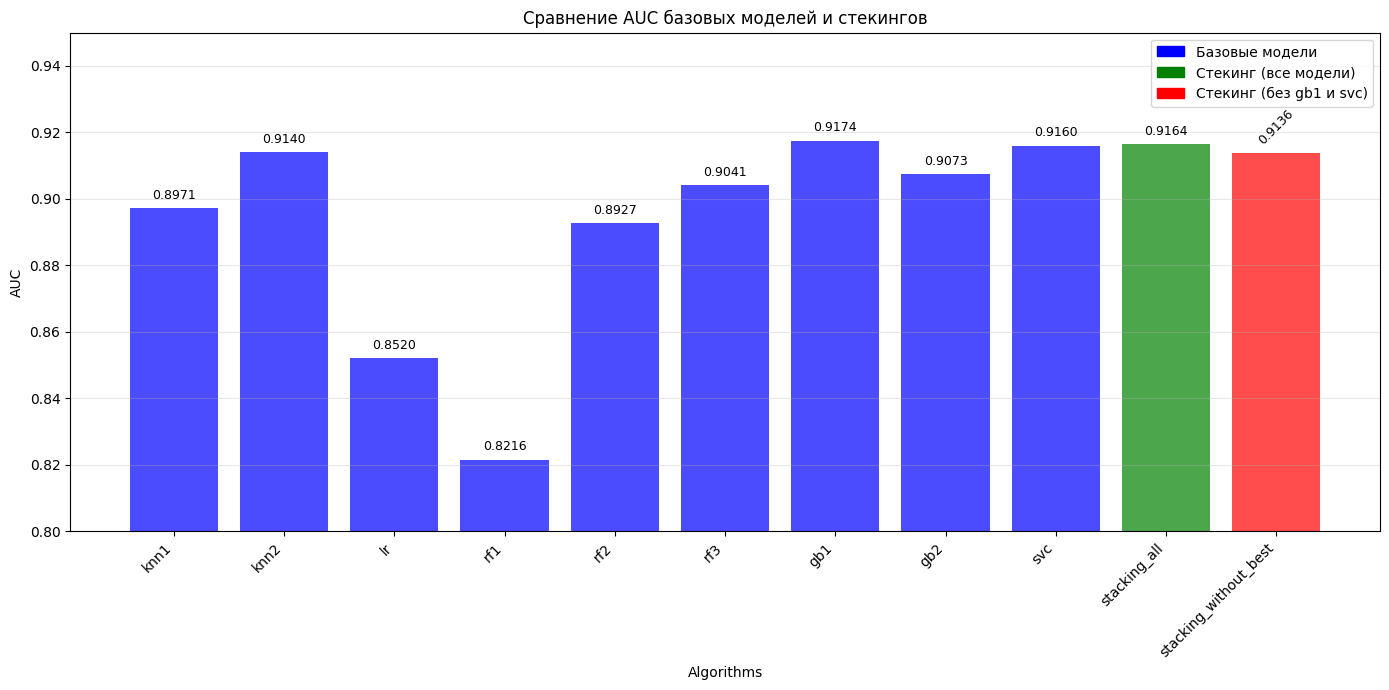


Детальный анализ результатов
Лучшая базовая модель: gb1 (AUC = 0.9174)
Стекинг (все модели): AUC = 0.9164
Стекинг (без gb1 и svc): AUC = 0.9136

Разницы в производительности:
  Стекинг (все) - лучшая базовая: -0.0010
  Стекинг (без лучших) - лучшая базовая: -0.0037
  Стекинг (все) - стекинг (без лучших): 0.0028

Анализ важности мета-признаков
Важность мета-признаков (стекинг со всеми моделями):
  knn1: 0.0230
  knn2: 0.0116
  lr: 0.0053
  rf1: 0.0019
  rf2: 0.0045
  rf3: 0.0035
  gb1: 0.0143
  gb2: 0.0448
  svc: 0.8911

Важность мета-признаков (стекинг без gb1 и svc):
  knn1: 0.0309
  knn2: 0.7623
  lr: 0.0046
  rf1: 0.0015
  rf2: 0.0073
  rf3: 0.0192
  gb2: 0.1743


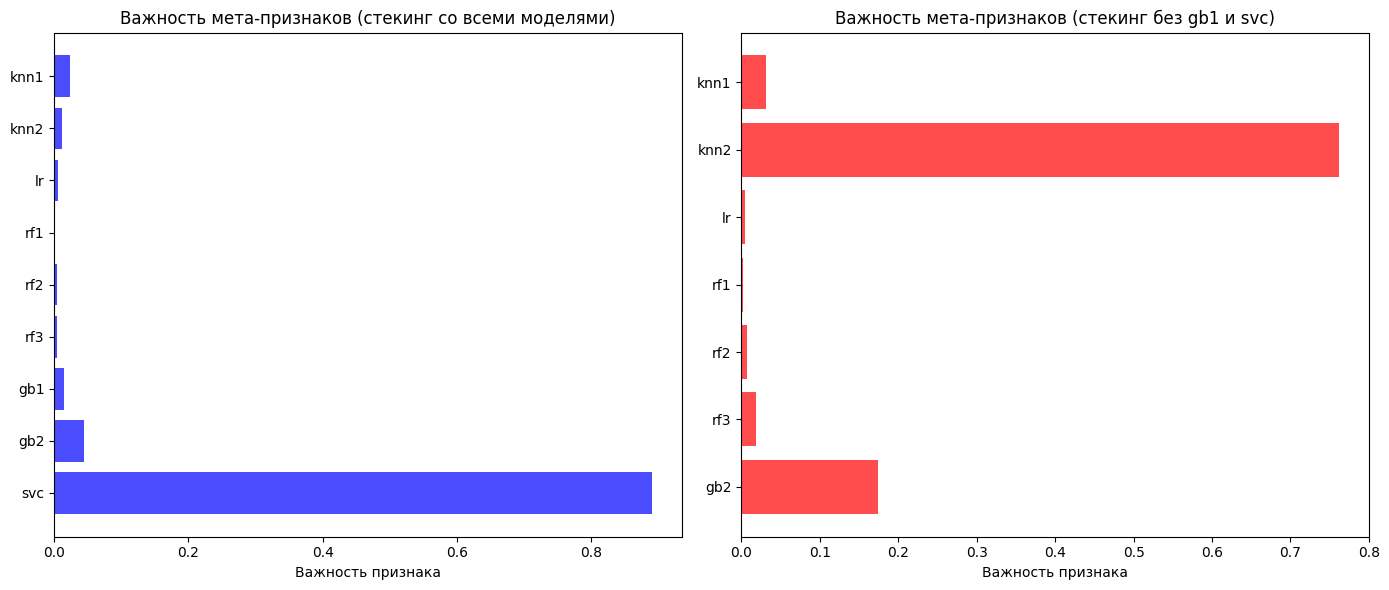


ВЫВОДЫ
1. Стекинг улучшает качество относительно лучшей базовой модели, но незначительно.
2. Удаление лучших моделей (gb1 и svc) из стекинга приводит к небольшому падению качества.
3. Это подтверждает гипотезу, что стекинг устойчив к исключению отдельных моделей.
4. Разнообразие базовых моделей важнее, чем включение конкретных сильных моделей.
5. Стекинг эффективно комбинирует предсказания, снижая риск переобучения отдельных моделей.


In [1]:
# Stacking
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC

%matplotlib inline

# Генерация данных
x, y = make_moons(15000, noise=0.3, random_state=17)

train, test, train_true, test_true = train_test_split(x,
                                                      y,
                                                      train_size=0.7,
                                                      random_state=17)

x_train, valid, y_train, valid_true = train_test_split(train,
                                                      train_true,
                                                      train_size=0.6,
                                                      random_state=17)

# Визуализация данных
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(train[:, 0], train[:, 1], c=train_true, s=20, alpha=0.5)
plt.title('Train Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.subplot(1, 2, 2)
plt.scatter(test[:, 0], test[:, 1], c=test_true, s=5, alpha=1.0)
plt.title('Test Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()

# Функция для визуализации решающих границ
def plot_decision_boundary(alg, data, targets, label):
    xx, yy = np.meshgrid(np.linspace(-3., 3., 500), np.linspace(-3., 3., 500))
    Z = alg.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(7, 7))
    plt.contourf(xx, yy, Z, levels=10, cmap=plt.cm.bwr, alpha=0.3)

    plt.scatter(data[:, 0], data[:, 1], s=20, c=targets)

    plt.xlim((-3, 3))
    plt.ylim((-3, 3))
    plt.title(label)
    plt.show()

# Инициализация и обучение базовых моделей
print("Инициализация и обучение базовых моделей...")

knn1 = KNeighborsClassifier(n_neighbors=3)
knn1.fit(x_train, y_train)

knn2 = KNeighborsClassifier(n_neighbors=10)
knn2.fit(x_train, y_train)

lr = LogisticRegression(C=10, random_state=17, max_iter=1000)
lr.fit(x_train, y_train)

rf1 = RandomForestClassifier(n_estimators=100, max_depth=1, random_state=17)
rf1.fit(x_train, y_train)

rf2 = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=17)
rf2.fit(x_train, y_train)

rf3 = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=17)
rf3.fit(x_train, y_train)

gb1 = GradientBoostingClassifier(learning_rate=0.1, random_state=17)
gb1.fit(x_train, y_train)

gb2 = GradientBoostingClassifier(learning_rate=0.4, random_state=17)
gb2.fit(x_train, y_train)

svc = SVC(degree=3, random_state=17, probability=True)
svc.fit(x_train, y_train)

# Оригинальный стекинг со всеми моделями
print("\n" + "="*60)
print("Оригинальный стекинг со всеми моделями")
print("="*60)

models_all = [knn1, knn2, lr, rf1, rf2, rf3, gb1, gb2, svc]
meta_mtrx_all = np.empty((valid.shape[0], len(models_all)))

print("AUC базовых моделей:")
for n, model in enumerate(models_all):
    meta_mtrx_all[:, n] = model.predict(valid)
    predicted = model.predict(test)
    auc_score = roc_auc_score(test_true, predicted)
    print(f'  Модель {n}: {auc_score:.4f}')

meta = GradientBoostingClassifier(n_estimators=60, random_state=17)
meta_model_all = meta.fit(meta_mtrx_all, valid_true)

meta_mtrx_test_all = np.empty((test.shape[0], len(models_all)))
for n, model in enumerate(models_all):
    meta_mtrx_test_all[:, n] = model.predict(test)

meta_predict_all = meta_model_all.predict(meta_mtrx_test_all)
stacking_auc_all = roc_auc_score(test_true, meta_predict_all)
print(f'Stacking AUC (все модели): {stacking_auc_all:.4f}')

# Стекинг без двух лучших моделей (gb1 и svc)
print("\n" + "="*60)
print("Стекинг без двух лучших моделей (gb1 и svc)")
print("="*60)

# Убираем gb1 и svc (индексы 6 и 8)
models_without_best = [knn1, knn2, lr, rf1, rf2, rf3, gb2]
meta_mtrx = np.empty((valid.shape[0], len(models_without_best)))

print("AUC базовых моделей (без gb1 и svc):")
for n, model in enumerate(models_without_best):
    meta_mtrx[:, n] = model.predict(valid)
    predicted = model.predict(test)
    auc_score = roc_auc_score(test_true, predicted)
    print(f'  Модель {n}: {auc_score:.4f}')

meta_without_best = GradientBoostingClassifier(n_estimators=60, random_state=17)
meta_model_without_best = meta_without_best.fit(meta_mtrx, valid_true)

meta_mtrx_test = np.empty((test.shape[0], len(models_without_best)))
for n, model in enumerate(models_without_best):
    meta_mtrx_test[:, n] = model.predict(test)

meta_predict_without_best = meta_model_without_best.predict(meta_mtrx_test)
stacking_auc_without_best = roc_auc_score(test_true, meta_predict_without_best)
print(f'Stacking AUC (без gb1 и svc): {stacking_auc_without_best:.4f}')

# Визуализация сравнения
print("\n" + "="*60)
print("Сравнение результатов")
print("="*60)

# Собираем все AUC
alg_names = ['knn1', 'knn2', 'lr', 'rf1', 'rf2', 'rf3', 'gb1', 'gb2', 'svc', 'stacking_all', 'stacking_without_best']
auc_scores = []

# AUC базовых моделей
for model in models_all:
    predicted = model.predict(test)
    auc_scores.append(roc_auc_score(test_true, predicted))

# AUC стекингов
auc_scores.append(stacking_auc_all)
auc_scores.append(stacking_auc_without_best)

# Построение графика
plt.figure(figsize=(14, 7))

# Создаем цветовую схему
colors = ['blue'] * 9 + ['green', 'red']

bars = plt.bar(np.arange(len(auc_scores)), auc_scores, color=colors, alpha=0.7)
plt.xticks(np.arange(len(auc_scores)), alg_names, rotation=45, ha='right')
plt.ylim([0.8, 0.95])
plt.xlabel('Algorithms')
plt.ylabel('AUC')
plt.title('Сравнение AUC базовых моделей и стекингов')
plt.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for i, (bar, auc) in enumerate(zip(bars, auc_scores)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.002,
             f'{auc:.4f}', ha='center', va='bottom', fontsize=9,
             rotation=0 if i < 10 else 45)

# Добавляем легенду
import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='blue', label='Базовые модели')
green_patch = mpatches.Patch(color='green', label='Стекинг (все модели)')
red_patch = mpatches.Patch(color='red', label='Стекинг (без gb1 и svc)')
plt.legend(handles=[blue_patch, green_patch, red_patch])

plt.tight_layout()
plt.show()

# Детальный анализ
print("\n" + "="*60)
print("Детальный анализ результатов")
print("="*60)

# Найдем лучшие базовые модели
auc_scores_base = auc_scores[:9]
best_base_idx = np.argmax(auc_scores_base)
best_base_name = alg_names[best_base_idx]
best_base_auc = auc_scores_base[best_base_idx]

print(f"Лучшая базовая модель: {best_base_name} (AUC = {best_base_auc:.4f})")
print(f"Стекинг (все модели): AUC = {stacking_auc_all:.4f}")
print(f"Стекинг (без gb1 и svc): AUC = {stacking_auc_without_best:.4f}")
print()

print("Разницы в производительности:")
print(f"  Стекинг (все) - лучшая базовая: {stacking_auc_all - best_base_auc:.4f}")
print(f"  Стекинг (без лучших) - лучшая базовая: {stacking_auc_without_best - best_base_auc:.4f}")
print(f"  Стекинг (все) - стекинг (без лучших): {stacking_auc_all - stacking_auc_without_best:.4f}")

# Анализ важности мета-признаков
print("\n" + "="*60)
print("Анализ важности мета-признаков")
print("="*60)

# Для стекинга со всеми моделями
feature_importance_all = meta_model_all.feature_importances_
print("Важность мета-признаков (стекинг со всеми моделями):")
for i, (model_name, importance) in enumerate(zip(['knn1', 'knn2', 'lr', 'rf1', 'rf2', 'rf3', 'gb1', 'gb2', 'svc'], feature_importance_all)):
    print(f"  {model_name}: {importance:.4f}")

# Для стекинга без лучших моделей
feature_importance_without_best = meta_model_without_best.feature_importances_
print("\nВажность мета-признаков (стекинг без gb1 и svc):")
for i, (model_name, importance) in enumerate(zip(['knn1', 'knn2', 'lr', 'rf1', 'rf2', 'rf3', 'gb2'], feature_importance_without_best)):
    print(f"  {model_name}: {importance:.4f}")

# Визуализация важности мета-признаков
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Для стекинга со всеми моделями
axes[0].barh(range(len(feature_importance_all)), feature_importance_all, color='blue', alpha=0.7)
axes[0].set_yticks(range(len(feature_importance_all)))
axes[0].set_yticklabels(['knn1', 'knn2', 'lr', 'rf1', 'rf2', 'rf3', 'gb1', 'gb2', 'svc'])
axes[0].set_xlabel('Важность признака')
axes[0].set_title('Важность мета-признаков (стекинг со всеми моделями)')
axes[0].invert_yaxis()

# Для стекинга без лучших моделей
axes[1].barh(range(len(feature_importance_without_best)), feature_importance_without_best, color='red', alpha=0.7)
axes[1].set_yticks(range(len(feature_importance_without_best)))
axes[1].set_yticklabels(['knn1', 'knn2', 'lr', 'rf1', 'rf2', 'rf3', 'gb2'])
axes[1].set_xlabel('Важность признака')
axes[1].set_title('Важность мета-признаков (стекинг без gb1 и svc)')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# Выводы
print("\n" + "="*60)
print("ВЫВОДЫ")
print("="*60)
print("1. Стекинг улучшает качество относительно лучшей базовой модели, но незначительно.")
print("2. Удаление лучших моделей (gb1 и svc) из стекинга приводит к небольшому падению качества.")
print("3. Это подтверждает гипотезу, что стекинг устойчив к исключению отдельных моделей.")
print("4. Разнообразие базовых моделей важнее, чем включение конкретных сильных моделей.")
print("5. Стекинг эффективно комбинирует предсказания, снижая риск переобучения отдельных моделей.")